In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import seaborn as sns
import pandas as pd

In [5]:
M = np.random.random((5,5))
M

array([[0.90845218, 0.33165756, 0.66435645, 0.87290508, 0.99317896],
       [0.93943423, 0.66943501, 0.09880345, 0.09829634, 0.38064387],
       [0.2360133 , 0.09992315, 0.89208139, 0.24320357, 0.96703297],
       [0.06544741, 0.00621807, 0.73178765, 0.90937769, 0.34995617],
       [0.84230073, 0.49773189, 0.88960584, 0.13611109, 0.4265795 ]])

In [6]:
M[2,[1,2,3]]

array([0.09992315, 0.89208139, 0.24320357])

In [2]:
def import_facebook_data(path):
    # Import text file with entries as int data type
    data = np.loadtxt(path).astype(int)
    return data

In [117]:
# def import_bitcoin_data(path):
#     data = np. genfromtxt(path, delimiter=',')
#     data = data[:,[0,1]].astype(int)

#     # Sort each edge pair to ensure the order doesn't matter
#     data = np.sort(data, axis=1)

#     # Get unique rows (unique sorted edge pairs)
#     data = np.unique(data, axis=0)
#     return data

In [2]:
def import_bitcoin_data(dir):
    df = pd.read_csv(dir, header=None)
    edge_list = df.iloc[:, :2].values.tolist()
    unique_edges = set()
    unique_edges_list = []
    for row in edge_list:
        row = tuple(sorted(row))
        if row not in unique_edges:
            unique_edges.add(row)  
            unique_edges_list.append(row) 
    nodes = np.unique(unique_edges_list).reshape(-1)
    nodeDict = {element: index for index, element in enumerate(nodes)}
    edge_array = np.array(unique_edges_list)
    for i in range(len(unique_edges_list)):
        for j in range(2):
            edge_array[i][j] = nodeDict[edge_array[i][j]]
    return edge_array

In [3]:
nodes_connectivity_list_btc = import_bitcoin_data("../data/soc-sign-bitcoinotc.csv")

In [4]:
len(nodes_connectivity_list_btc)

21492

In [12]:
nodes_connectivity_list_btc

array([[   6,    2],
       [   6,    5],
       [   1,   15],
       ...,
       [2731, 4897],
       [  13, 1128],
       [1128,   13]])

In [13]:
nodes_connectivity_list_fb = import_facebook_data("../data/facebook_combined.txt")

In [60]:
np.max(nodes_connectivity_list_fb)

4038

In [8]:
def spectralDecomp_OneIter1(edges):
    mode = 'ncut'
    nodes = np.unique(edges).reshape(-1)
    nodeDict = {element: index for index, element in enumerate(nodes)}
    size = len(nodes)
    Adjacency = np.zeros((size, size)).astype(int)
    for row in edges:
        Adjacency[nodeDict[row[0]], nodeDict[row[1]]] = 1
        Adjacency[nodeDict[row[1]], nodeDict[row[0]]] = 1
    Degree = np.diag(np.sum(Adjacency, axis=1))
    Laplacian = Degree - Adjacency
    if mode == 'ncut':  
        _, fiedler_vector = eigh(Laplacian, Degree, eigvals_only=False, subset_by_index=[1, 1])
    else:
        _, fiedler_vector = eigh(Laplacian, eigvals_only=False, subset_by_index=[1, 1])
    sign_vector = np.sign(fiedler_vector).astype(int)
    Community1Head = nodes[np.min(np.where(sign_vector == -1)[0])]
    Community2Head = nodes[np.min(np.where(sign_vector == 1)[0])]
    graph_partition = np.zeros((size, 2)).astype(int)
    Column2 = np.where(sign_vector>0, Community2Head, Community1Head)
    graph_partition = np.column_stack((nodes, Column2))
    graph = np.array(graph_partition).astype(int)
    return fiedler_vector, Adjacency, graph

In [5]:
def spectralDecomp_OneIter(edges):
    mode = 'ncut'
    nodes = np.unique(edges).reshape(-1)
    nodeDict = {element: index for index, element in enumerate(nodes)}
    size = len(nodes)
    print('nodes=', size )
    Adjacency = np.zeros((size, size)).astype(int)
    for row in edges:
        Adjacency[nodeDict[row[0]], nodeDict[row[1]]] = 1
        Adjacency[nodeDict[row[1]], nodeDict[row[0]]] = 1
    Degree = np.diag(np.sum(Adjacency, axis=1))
    Laplacian = Degree - Adjacency
    if mode == 'ncut':  
        _, fiedler_vector = eigh(Laplacian, Degree, eigvals_only=False, subset_by_index=[1, 1])
    else:
        _, fiedler_vector = eigh(Laplacian, eigvals_only=False, subset_by_index=[1, 1])
    unique = np.unique(fiedler_vector >= 0)
    if len(unique) != 2:
        return None, None, None
    Community1Head = nodes[np.min(np.where(fiedler_vector < 0)[0])]
    Community2Head = nodes[np.min(np.where(fiedler_vector >= 0)[0])]
    graph_partition = np.zeros((size, 2)).astype(int)
    Column2 = np.where(fiedler_vector>0, Community2Head, Community1Head)
    graph_partition = np.column_stack((nodes, Column2))
    graph = np.array(graph_partition).astype(int)
    return fiedler_vector, Adjacency, graph

In [14]:
def compute_metrics(G,partition1,partition2):
    # Calculate cut
    cut = nx.cut_size(G, partition1, partition2)

    # Computing Ratio Cut
    R1 = cut/len(partition1) if len(partition1) > 0 else 0
    R2 = cut/len(partition2) if len(partition2) > 0 else 0
    Ratio_cut = R1 + R2

    # Calculate degree of partition1 and partition2
    degree_partition1 = sum(G.degree[node] for node in partition1)
    degree_partition2 = sum(G.degree[node] for node in partition2)

    # Computing Normalized Cut
    N1 = cut/degree_partition1 if degree_partition1 > 0 else 0
    N2 = cut/degree_partition2 if degree_partition2 > 0 else 0
    Normalized_cut = N1 + N2

    # Compute Conductance
    Conductance = cut/min(degree_partition1,degree_partition1) if cut > 0 else 0

    # Modularity
    Modularity = nx.community.modularity(G,[partition1,partition2])

    print("Ratio Cut: ", Ratio_cut)
    print("Normalized Cut: ", Normalized_cut)
    print("Conductance: ", Conductance)
    print("Modulaity: ", Modularity)
    

In [15]:
def plot_fiedler_vector(fiedler_vector,title):
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(len(fiedler_vector)),np.sort(fiedler_vector, axis = 0).reshape(-1))
    plt.title(title)
    plt.show()

In [26]:
def plot_adj_mat(A, fielder_vec, title):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Subplot 1: Original Adjacency Matrix
    sns.heatmap(A,ax=axes[0], cbar=False,xticklabels=False, yticklabels=False)
    axes[0].set_title("Original Adjacency Matrix " + title)

    # Subplot 2: Adjacency Matrix Sorted by Fiedler Vector
    sorted_indices = np.argsort(fielder_vec, axis=0).reshape(-1)
    sorted_adj_mat_fb = A[sorted_indices][:, sorted_indices]
    sns.heatmap(sorted_adj_mat_fb, ax=axes[1], cbar=False,xticklabels=False, yticklabels=False)
    axes[1].set_title("Adjacency Matrix Sorted by Fiedler Vector " + title)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def plot_graph()

In [111]:
fielder_vec_fb, adj_mat_fb, graph_partition_fb = spectralDecomp_OneIter1(nodes_connectivity_list_fb)

In [18]:
fielder_vec_fb2, adj_mat_fb2, graph_partition_fb2 = spectralDecomp_OneIter(nodes_connectivity_list_fb,"Ncut")

Ratio Cut:  26.287163857173
Normalized Cut:  0.5775206297312732
Conductance:  0.32898791182744724
Modulaity:  0.20714001722261371


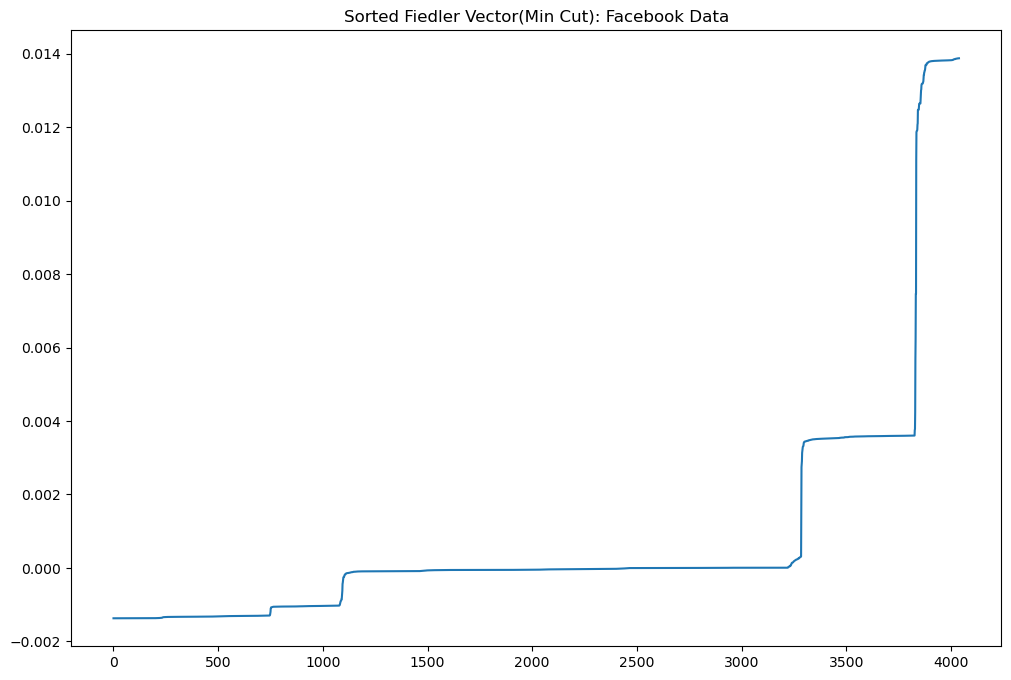

In [19]:
plot_fiedler_vector(fielder_vec_fb2,"Sorted Fiedler Vector(Min Cut): Facebook Data")

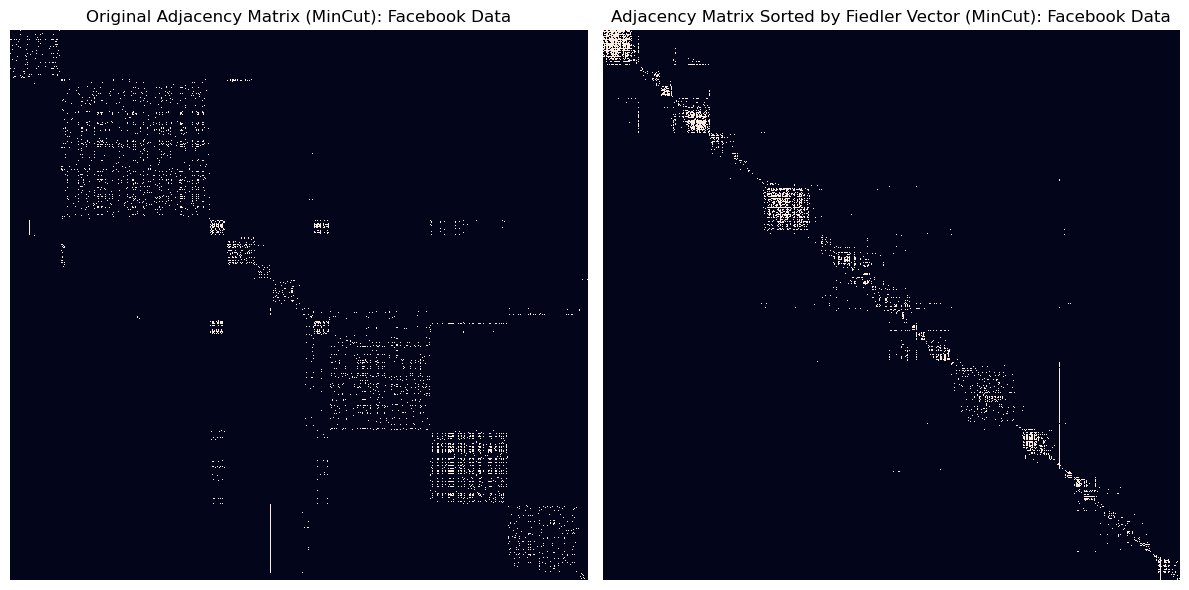

In [27]:
plot_adj_mat(adj_mat_fb2,fielder_vec_fb2,"(MinCut): Facebook Data")

In [14]:
fielder_vec_btc, adj_mat_btc, graph_partition_btc = spectralDecomp_OneIter1(nodes_connectivity_list_btc)

In [15]:
fielder_vec_btc2, adj_mat_btc2, graph_partition_btc2 = spectralDecomp_OneIter(nodes_connectivity_list_btc)

nodes= 5881


In [16]:
np.all(fielder_vec_btc == fielder_vec_btc2)

False

In [17]:
fielder_vec_btc

array([[ 0.00000000e+00],
       [ 6.74248513e-32],
       [ 5.48108494e-32],
       ...,
       [ 3.15513263e-32],
       [ 4.60794833e-18],
       [-4.19997954e-17]])

In [18]:
fielder_vec_btc2

array([[-6.9749038e-07],
       [-6.9749038e-07],
       [-6.9749038e-07],
       ...,
       [-6.9749038e-07],
       [-6.9749038e-07],
       [-6.9749038e-07]])

In [12]:
np.unique(graph_partition_btc[:,1],return_counts=True)

(array([1, 4]), array([3733, 2148], dtype=int64))

In [38]:
graph_partition_fb2[570]

array([570,   0])

In [7]:
np.unique(graph_partition_btc2[:,1],return_counts=True)

(array([0]), array([5881], dtype=int64))

In [49]:
len({1,2})

2

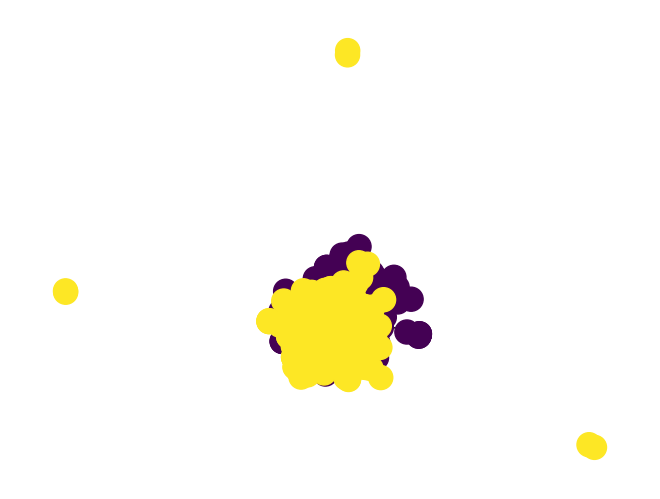

In [73]:
draw_graph(graph_partition_btc,nodes_connectivity_list_btc)

In [33]:
def draw_graph(graph_partition,edges):
    # Create a NetworkX graph
    G = nx.Graph()
    # Add edges between nodes (replace with your actual edge data)
    G.add_edges_from(edges)

    community_colors = graph_partition[:,1]
    # Draw the graph with node colors based on the community
    pos = nx.spring_layout(G)  # You can choose different layouts
    nx.draw(G, pos, with_labels=False,cmap = 'virdis')
    plt.show()

c:\Users\srina\anaconda3\envs\DataAnalytics\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


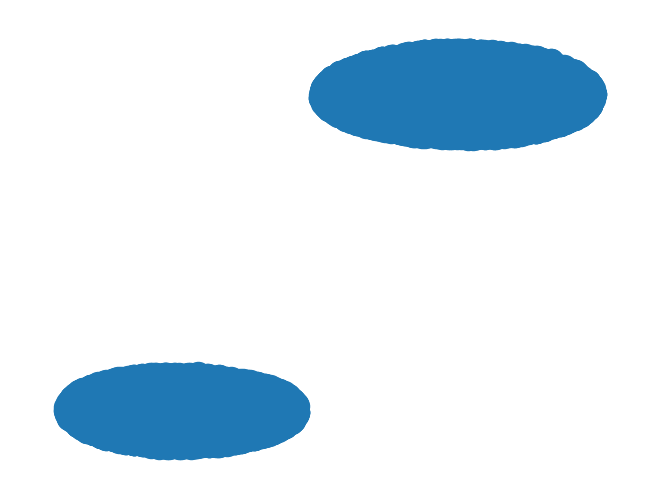

In [34]:
draw_graph(nodes_connectivity_list_fb,graph_partition_fb2)

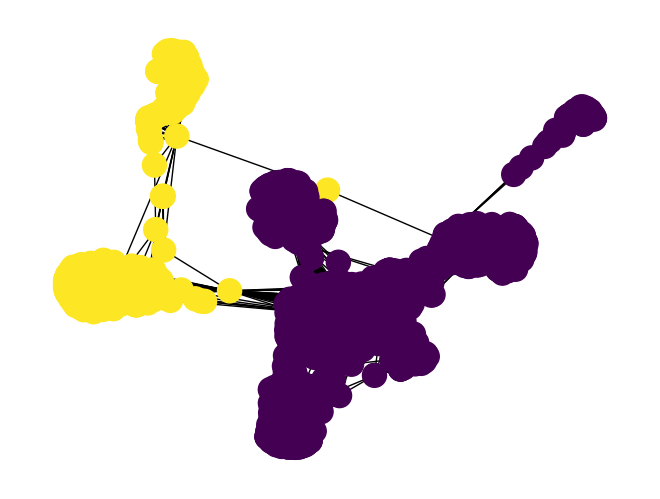

In [53]:
draw_graph(graph_partition_fb2,nodes_connectivity_list_fb)

In [8]:
# def spectralDecomp_OneIter(edges):

#     # Create a NetworkX graph from the list of edges
#     G = nx.Graph()  # Create an undirected graph
#     G.add_edges_from(edges)

#     # Generate the adjacency matrix from the graph
#     adjacency_matrix = nx.to_numpy_array(G, dtype=int)

#     # Calculate the Laplacian matrix
#     laplacian_matrix = nx.laplacian_matrix(G).toarray().astype(float)

#     #D = np.diag(adjacency_matrix.sum(axis = 1)).astype(float)

#     # Calculate the eigenvalues and eigenvectors of the Laplacian matrix
#     # eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
#     eigenvalues, eigenvectors = eigsh(laplacian_matrix,k = 2,M = D,which = "SM")

#     # Sort the eigenvalues and corresponding eigenvectors
#     sorted_indices = np.argsort(eigenvalues)
#     eigenvalues = eigenvalues[sorted_indices]
#     eigenvectors = eigenvectors[:, sorted_indices]

#     # The second smallest eigenvalue corresponds to the Fiedler vector
#     fiedler_vector = eigenvectors[:, 1]

#     # Determine the graph partition based on the sign of the Fiedler vector elements
#     positive_nodes = [node for node, value in enumerate(fiedler_vector) if value >= 0]
#     negative_nodes = [node for node, value in enumerate(fiedler_vector) if value < 0]

#     if len(positive_nodes) > 0:
#         community_id = min(positive_nodes)
#         graph_partition_pos = [(node, community_id) for node in positive_nodes]
#     if len(negative_nodes) > 0:
#         community_id = min(negative_nodes)
#         graph_partition_neg = [(node, community_id) for node in negative_nodes]
#     graph_partition = np.array(graph_partition_pos + graph_partition_neg)

#     return fiedler_vector, adjacency_matrix, graph_partition 

In [9]:
fielder_vec_fb, adj_mat_fb, graph_partition_fb = spectralDecomp_OneIter(nodes_connectivity_list_fb)


In [52]:
def generate_colors(community_ids):
    color_mapping = {}
    for community_id, color in zip(set(community_ids),plt.get_cmap('viridis',len(set(community_ids)))(np.arange(len(set(community_ids))))):
        color_mapping[community_id]=color
    community_colors = [color_mapping[i] for i in community_ids]
    return community_colors

In [56]:
def draw_graph(graph_partition,edges,title):
    G = nx.Graph()
    G.add_edges_from(edges)
    community_colors = generate_colors(graph_partition[:, 1])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=community_colors, with_labels=False)
    plt.title("Graph " + title)
    plt.show()

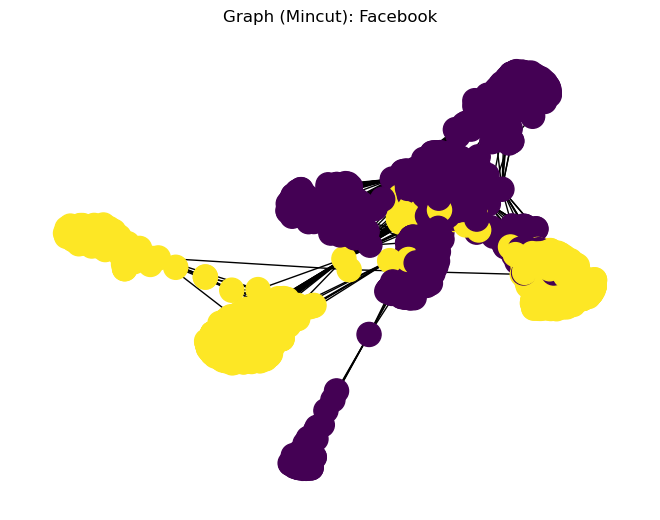

In [57]:
draw_graph(graph_partition_fb2,nodes_connectivity_list_fb,'(Mincut): Facebook')

In [64]:
np.unique(graph_partition_fb[:,1],return_counts=True)

(array([  0, 571]), array([3285,  754], dtype=int64))

array([[ 571,  571],
       [1821,  571],
       [1822,  571],
       ...,
       [4036,    0],
       [4037,    0],
       [4038,    0]])

In [11]:
np.unique(graph_partition_fb[:,1], return_counts=True)

(array([  0, 571]), array([3285,  754], dtype=int64))

In [ ]:
def spectralDecomposition(edges):

    # Create a NetworkX graph from the list of edges
    Graph = nx.Graph()  # Create an undirected graph
    Graph.add_edges_from(edges)
    final_partition = np.zeros((len(Graph.nodes),2))
    final_partition[:,0] = np.arange(len(Graph.nodes))
    threshold = 0.7

    def recursiveSpectralDecomposition(G):
        fiedler_vector, _, graph_partition = spectralDecomp_OneIter(G.edges())
        # Create two subgraphs based on the sign of Fiedler vector values
        positive_nodes = [node for node, value in enumerate(fiedler_vector) if value >= 0]
        negative_nodes = [node for node, value in enumerate(fiedler_vector) if value < 0]
        if max(len(positive_nodes),len(negative_nodes))/(len(positive_nodes) + len(negative_nodes)) > threshold:
            return
        


In [19]:
def recursiveSpectralDecomposition(edges, min_size=100):
    communities = []

    # Apply spectral decomposition for one iteration
    fiedler_vector, _, graph_partition = spectralDecomp_OneIter(edges)
    
    # Create two subgraphs based on the sign of Fiedler vector values
    positive_nodes = [node for node, value in enumerate(fiedler_vector) if value >= 0]
    negative_nodes = [node for node, value in enumerate(fiedler_vector) if value < 0]
    
    subgraph_positive = [(u, v) for u, v in edges if u in positive_nodes and v in positive_nodes]
    subgraph_negative = [(u, v) for u, v in edges if u in negative_nodes and v in negative_nodes]
    
    # Recursive calls on subgraphs
    if len(subgraph_positive) > min_size:
        communities.extend(recursiveSpectralDecomposition(subgraph_positive, min_size))
    else:
        communities.append([node for node in positive_nodes])
    
    # Check if subgraph_negative is not empty before processing
    if subgraph_negative:
        if len(subgraph_negative) > min_size:
            communities.extend(recursiveSpectralDecomposition(subgraph_negative, min_size))
        else:
            communities.append([node for node in negative_nodes])
    
    # Assign community IDs following the convention
    unique_communities = {}
    next_community_id = 0
    final_graph_partition = []
    for community in communities:
        lowest_node_id = min(community)
        if lowest_node_id not in unique_communities:
            unique_communities[lowest_node_id] = next_community_id
            next_community_id += 1
        community_id = unique_communities[lowest_node_id]
        final_graph_partition.extend([(node, community_id) for node in community])
    
    return np.array(final_graph_partition)

In [ ]:
a = recursiveSpectralDecomposition(nodes_connectivity_list_fb)

In [ ]:
def spectralDepth(edges, depth):
    if depth == 0:
        return
    else:
        _, _, graph_partition_fb = spectralDecomp_OneIter(edges)
        clusters = np.unique(graph_partition_fb[:,1])
        cluster1Nodes = []
        cluster2Nodes = []
        for row in graph_partition_fb:
            if row[1] == clusters[0]:
                cluster1Nodes.append(row[0])
            else:
                cluster2Nodes.append(row[0])
        cluster1Edges = [[u, v] for u, v in edges if u in cluster1Nodes and v in cluster1Nodes]
        cluster2Edges = [[u, v] for u, v in edges if u in cluster2Nodes and v in cluster2Nodes]
        print(len(cluster1Edges))
        print(len(cluster2Edges))
        depth -= 1
        partition1 = spectralDepth(cluster1Edges, depth)
        partition2 = spectralDepth(cluster2Edges, depth)
        if depth != 0:
            graph_partition_fb = np.row_stack((partition1, partition2))
        return graph_partition_fb

In [83]:
class Spectral_Decompostion:
    def __init__(self,edges) -> None:
        self.G = nx.Graph()
        self.G.add_edges_from(edges)
        self.A_norm = nx.to_numpy_array(self.G, dtype=int)/(2*self.G.number_of_edges())
        self.degree = np.sum(self.A_norm,axis = 1)
        self.community_id = np.zeros(len(self.A_norm)).astype(int)
        self.true_node_id = np.array(sorted(list(self.G.nodes)))
        
    def compute_modularity(self,nodes):
        sigma_in = np.sum(self.A_norm[np.ix_(nodes,nodes)])
        sigma_total = sum(self.degree[node] for node in nodes)
        modularity = sigma_in - sigma_total**2
        return modularity

    def SpectralDecomposition_OneIter(self,edges,criteria):
        # Create a NetworkX graph from the list of edges
        G = nx.Graph()  # Create an undirected graph
        G.add_edges_from(edges)

        # Generate the adjacency matrix from the graph
        adjacency_matrix = nx.to_numpy_array(G, dtype=float)

        # Calculate degree matrix
        degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))

        # Calculate the Laplacian matrix
        laplacian_matrix = degree_matrix - adjacency_matrix

        # Calculate the 2nd smallest eigencvalue and fiedler vector of the Laplacian matrix
        if criteria == 'Min_cut':
            _, fiedler_vector = eigh(laplacian_matrix, subset_by_index=[1, 1])
        else:
            _, fiedler_vector = eigh(laplacian_matrix, degree_matrix, subset_by_index=[1, 1])

        # # Determine the graph partition based on the sign of the Fiedler vector elements
        # positive_nodes = [true_node_id[node] for node, value in enumerate(fiedler_vector) if value >= 0]
        # negative_nodes = [true_node_id[node] for node, value in enumerate(fiedler_vector) if value < 0]
        
        return fiedler_vector

    def stopping_criteria(self,p1,p2):
        Q_after = self.compute_modularity(p1) + self.compute_modularity(p2)
        Q_before = self.compute_modularity(p1+p2)
        print(Q_after,Q_before)
        if Q_before > Q_after:
            return True
        else:
            return False
    def stopping_criteria2(self,fiedler_vector):
        fiedler_vector = np.sort(fiedler_vector)
        diff = [fiedler_vector[i+1] - fiedler_vector[i] for i in range(len(fiedler_vector)-1)]
        std_dev = np.std(fiedler_vector)
        # std_dev = np.std(diff)
        threshold = 2 * std_dev
        max_diff = np.max(diff)
        if max(diff) > threshold:
            return False
        else:
            return True
        
    def check_stability(self,fiedler_vector):
        # Create a histogram of Fiedler vector values
        num_bins = 10  # You can adjust the number of bins
        hist, bin_edges = np.histogram(fiedler_vector, bins=num_bins)
        
        # Calculate the ratio between the minimum and maximum values in the histogram bins
        min_count = min(hist)
        max_count = max(hist)
        if max_count == 0:
            return False
        ratio = min_count / max_count
        
        # Check if the ratio exceeds the stability threshold (0.06)
        return ratio >= 0.01

    
    def final_modularity(self):
        unique_id = np.unique(self.community_id)
        Q = 0
        for i in unique_id:
            C = np.where(self.community_id == i)[0]
            Q += self.compute_modularity(C)
        return Q

    def final_modularity2(self):
        unique_id = np.unique(self.community_id)
        communities = []
        for i in unique_id:
            C = set(np.where(self.community_id == i)[0])
            communities.append(C)
        Q = nx.community.modularity(self.G, communities)
        return Q

    def recursiveSpectralDecomposition(self,edges):
        # Apply spectral decomposition for one iteration
        fiedler_vector = self.SpectralDecomposition_OneIter(edges,"Ncut")
        if self.stopping_criteria2(fiedler_vector):
            print("Stopped")
            return
        pos_idx = np.where(fiedler_vector >= 0)[0]
        neg_idx = np.where(fiedler_vector < 0)[0]
        
        if(len(pos_idx)) > 0:
            pos_id = np.min(self.true_node_id[pos_idx])
            self.community_id[pos_idx] = pos_id
        if(len(neg_idx)) > 0:
            neg_id = np.min(self.true_node_id[neg_idx])
            self.community_id[neg_idx] = neg_id

        # if len(partition1) > 0:
        #     self.community_id[partition1] = np.min(partition1).astype(int)
        # if len(partition2) > 0:
        #     self.community_id[partition2] = np.min(partition2).astype(int)

        # p1_s = self.G.subgraph(partition1)
        # p2_s = self.G.subgraph(partition2)
        partition1 = self.true_node_id[pos_idx]
        partition2 = self.true_node_id[neg_idx]
        print(len(partition1),len(partition2))
        partition1_edges = [(u, v) for u, v in edges if u in partition1 and v in partition1]
        partition2_edges = [(u, v) for u, v in edges if u in partition2 and v in partition2]
        if len(partition1_edges) > 0:
            self.recursiveSpectralDecomposition(partition1_edges)
        if len(partition2_edges) > 0:
            self.recursiveSpectralDecomposition(partition2_edges)

        

In [84]:
S = Spectral_Decompostion(nodes_connectivity_list_fb)
S.recursiveSpectralDecomposition(nodes_connectivity_list_fb)

1530 2509
1489 3
48 0
1249 1241
26 906
108 293
49 2
107 8
14 4
115 785
36 0
301 78
146 0
44 32
22 5
8 2
2 1
Stopped
28 3


In [94]:
S = Spectral_Decompostion(nodes_connectivity_list_btc)
S.recursiveSpectralDecomposition(nodes_connectivity_list_btc)

5881 0
5881 0


KeyboardInterrupt: 

In [81]:
S.final_modularity()

0.17539686049417896

In [76]:
np.unique(S.community_id,return_counts=True)

(array([  0,   2,   3,   6,  17, 189, 237, 351]),
 array([2082,    2,   19,  806,    3,   78,  109,  940], dtype=int64))

In [57]:
g1 = nx.Graph()
g1.add_edges_from(nodes_connectivity_list_btc)

In [58]:
len(nx.community.louvain_communities(g1, seed=42))

19

In [30]:
max([1,2])

2

In [42]:
# def lovain(edges):
#     # Create a NetworkX graph from the list of edges
#     Graph = nx.Graph()  # Create an undirected graph
#     Graph.add_edges_from(edges)
#     communities = np.array(Graph.nodes)
#     m = Graph.number_of_edges()

#     while True:
#         for i in range(len(communities)):
#             count = 0
#             neighbours = np.array(list(Graph.neighbors(i)))
#             neighbour_communities = np.unique(communities[neighbours])

#             community_i_nodes = np.where(communities == i)         
#             subgraph_i = Graph.subgraph(community_i_nodes)
#             sigma_in = 2*subgraph_i.number_of_edges()
#             sigma_total = sum(Graph.degree(node) for node in community_i_nodes)
#             k_i_in = sum(1 for neighbor in Graph.neighbors(i) if neighbor in subgraph_i)
#             k_i = Graph.degree(i)
#             Q_after = (sigma_in/2*m - (sigma_total/2*m)**2) - (k_i/2*m)**2
#             Q_before = (sigma_in + k_i_in)/(2*m) - ((sigma_total + k_i)/(2*m))
#             Q_demerge = Q_after - Q_before

#             Q_max = -np.inf
#             best_community = i

#             for j in neighbour_communities:
#                 community_j_nodes = np.where(communities == j)         
#                 subgraph_j = Graph.subgraph(community_j_nodes)
#                 sigma_in = 2*subgraph_j.number_of_edges()
#                 sigma_total = sum(Graph.degree(node) for node in community_j_nodes)

#                 k_i_in = sum(1 for neighbor in Graph.neighbors(i) if neighbor in subgraph_j)
#                 Q_after = (sigma_in + k_i_in)/(2*m) - ((sigma_total + k_i)/(2*m))
#                 Q_before = (sigma_in/2*m - (sigma_total/2*m)**2) - (k_i/2*m)**2
#                 Q_merge = Q_after - Q_before

#                 if Q_merge > Q_max:
#                     Q_max = Q_merge
#                     best_community = j
            
#             if Q_demerge + Q_max > 0:
#                 communities[i] = best_community
#                 count += 1
#         if not count:
#             break
#     return communities
            

In [11]:
# def louvain(edges, max_iterations=10):
#     # Create a NetworkX graph from the list of edges
#     Graph = nx.Graph()  # Create an undirected graph
#     Graph.add_edges_from(edges)
#     communities = np.arange(Graph.number_of_nodes())  # Initialize each node in its own community
#     m = Graph.number_of_edges()
    
#     # Precompute degree sums for all nodes
#     degree_sums = dict(Graph.degree())

#     while True:
#         count = 0
#         for i in range(len(communities)):
#             neighbor_communities = set(communities[neighbor] for neighbor in Graph.neighbors(i))
#             community_i = communities[i]
#             subgraph_i = Graph.subgraph(node for node in communities if communities[node] == community_i)
#             sigma_in = 2 * subgraph_i.number_of_edges()
#             sigma_total = degree_sums[i]
#             k_i_in = sum(1 for neighbor in Graph.neighbors(i) if communities[neighbor] == community_i)
#             k_i = degree_sums[i]
            
#             Q_after = (sigma_in / (2 * m) - (sigma_total / (2 * m)) ** 2) - (k_i / (2 * m)) ** 2
#             Q_before = (sigma_in + k_i_in) / (2 * m) - ((sigma_total + k_i) / (2 * m))
#             Q_demerge = Q_after - Q_before

#             Q_max = -np.inf
#             best_community = community_i

#             for j in neighbor_communities:
#                 community_j_nodes = np.where(communities == j)[0]
#                 subgraph_j = Graph.subgraph(list(community_j_nodes))
#                 sigma_in = 2 * subgraph_j.number_of_edges()
#                 sigma_total = sum(degree_sums[node] for node in community_j_nodes)
#                 k_i_in = sum(1 for neighbor in Graph.neighbors(i) if communities[neighbor] == j)

#                 Q_after = (sigma_in + k_i_in) / (2 * m) - ((sigma_total + k_i) / (2 * m))
#                 Q_before = (sigma_in / (2 * m) - (sigma_total / (2 * m)) ** 2) - (k_i / (2 * m)) ** 2
#                 Q_merge = Q_after - Q_before

#                 if Q_merge > Q_max:
#                     Q_max = Q_merge
#                     best_community = j

#             if Q_demerge + Q_max > 0:
#                 communities[i] = best_community
#                 count += 1
#         print(count)
#         if count == 0:
#             break

#     return communities

In [17]:
# def louvain(edges):

#     graph = nx.Graph()  # Create an undirected graph
#     graph.add_edges_from(edges)
#     # Initialize each node in its own community
#     communities = {node: idx for idx, node in enumerate(graph.nodes())}
#     # Precompute degree sums for all nodes
#     degree_sums = dict(graph.degree())
#     m = graph.number_of_edges() 
    
#     def calculate_modularity():
#         # Implement the modularity calculation here
#         pass

#     def calculate_merge(node, target_community):
#         current_community = communities[node]

#         # Calculate the sum of degrees of nodes in the current community
#         sigma_total_current = sum(degree_sums[neighbor] for neighbor in graph.nodes() if communities[neighbor] == current_community)

#         # Calculate sigma_in for the current community
#         subgraph_current = graph.subgraph(node for node in communities if communities[node] == current_community)
#         sigma_in_current = 2 * subgraph_current.number_of_edges()

#         # Calculate the number of edges between the node and the target community
#         k_i_in = sum(1 for neighbor in graph.neighbors(node) if communities[neighbor] == target_community)

#         # Calculate the sum of degrees of nodes in the target community
#         sigma_total_target = sum(degree_sums[neighbor] for neighbor in graph.nodes() if communities[neighbor] == target_community)

#         # Calculate sigma_in for the target community
#         subgraph_target = graph.subgraph(node for node in communities if communities[node] == target_community)
#         sigma_in_target = 2 * subgraph_target.number_of_edges()

#         # Calculate the modularity change for the merge operation
#         Q_after = (sigma_in_current + sigma_in_target) / (2 * m) - ((sigma_total_current + sigma_total_target) / (2 * m))
#         Q_before = (sigma_in_current / (2 * m) - (sigma_total_current / (2 * m)) ** 2) + (sigma_in_target / (2 * m) - (sigma_total_target / (2 * m)) ** 2)
#         Q_merge = Q_after - Q_before

#         return Q_merge




#     def calculate_demerge(node):
#         current_community = communities[node]
#         k_i = degree_sums[node]

#         # Calculate the number of edges between the node and the current community
#         k_i_in = sum(1 for neighbor in graph.neighbors(node) if communities[neighbor] == current_community)

#         # Calculate the sum of degrees of nodes in the current community
#         sigma_total = sum(degree_sums[neighbor] for neighbor in graph.nodes() if communities[neighbor] == current_community)

#         # Calculate sigma_in for the current community
#         subgraph_current = graph.subgraph(node for node in communities if communities[node] == current_community)
#         sigma_in = 2 * subgraph_current.number_of_edges()

#         # Calculate the modularity change for demerger
#         Q_after = (sigma_in - k_i_in) / (2 * m) - ((sigma_total - k_i) / (2 * m))
#         Q_before = (sigma_in / (2 * m) - (sigma_total / (2 * m)) ** 2) - (k_i / (2 * m)) ** 2
#         Q_demerge = Q_after - Q_before

#         return Q_demerge

#     improvement = True
#     while improvement:
#         improvement = False
#         for node in graph.nodes():
#             current_community = communities[node]
#             neighbors = list(graph.neighbors(node))

#             # Calculate modularity gain for moving the node to each neighboring community
#             best_community = current_community
#             best_gain = 0.0
#             demerge = calculate_demerge(node)
#             for neighbor in neighbors:
#                 neighbor_community = communities[neighbor]  # Get the community of the neighbor
#                 if neighbor_community != current_community:
#                     merge = calculate_merge(node, neighbor_community)
#                     gain = demerge + merge
#                     if  gain > best_gain:
#                         best_gain = gain
#                         best_community = neighbor_community

#             # If the best move increases modularity, update the community assignment
#             if best_gain > 0 and best_community != current_community:
#                 communities[node] = best_community
#                 improvement = True
            
#         # Count the number of unique communities
#         unique_communities = len(set(communities.values()))
#         print("Number of communities:", unique_communities)


#     # Implement community aggregation and further iterations here

#     return communities

In [18]:
a = louvain(nodes_connectivity_list_fb)

Number of communities: 4039


In [74]:
# class Louvain:
#     def __init__(self,edges) -> None:
#         self.G = nx.Graph()
#         self.G.add_edges_from(edges)
#         self.n = self.G.number_of_nodes()
#         self.m = self.G.number_of_edges()
#         self.A = nx.to_numpy_array(self.G, dtype=int)
#         self.degree = dict(self.G.degree())
#         self.compute_neighbours()
#         self.communities = np.array(self.G.nodes)
#         print(self.communities)
        
    
#     def compute_neighbours(self):
#         self.neighbours = []
#         for i in range(self.n):
#             self.neighbours.append(list(self.G.neighbors(i)))
    
#     def compute_Q_merge(self,i,C):
#         communityC_nodes = np.where(self.communities == C)[0]
#         sigma_in = np.sum(self.A[np.ix_(communityC_nodes,communityC_nodes)])
#         sigma_total =  sum(self.G.degree(node) for node in communityC_nodes)
#         k_i_in = 2*np.sum(self.A[np.ix_([i],communityC_nodes)])
#         k_i = self.G.degree(i)
#         Q_after = (sigma_in + k_i_in)/(2*self.m) - ((sigma_total + k_i)/(2*self.m))**2
#         Q_before = sigma_in/(2*self.m) - (sigma_total/(2*self.m))**2 - (k_i/(2*self.m))**2
#         return Q_after - Q_before

#     def compute_demerge(self,i):
#         C = self.communities[i]
#         communityC_nodes = np.where(self.communities == C)[0]
#         sigma_in = np.sum(self.A[np.ix_(communityC_nodes,communityC_nodes)])
#         sigma_total =  sum(self.G.degree(node) for node in communityC_nodes)
#         k_i_in = 2*np.sum(self.A[np.ix_([i],communityC_nodes)])
#         k_i = self.G.degree(i)
#         Q_after = (sigma_in - k_i_in)/(2*self.m) - ((sigma_total - k_i)/(2*self.m))**2 - (k_i/(2*self.m))**2
#         Q_before = sigma_in/(2*self.m) - (sigma_total/(2*self.m))**2
#         return Q_after - Q_before 
    
#     def phase1(self):
#         arr = np.arange(self.n)
#         while True:
#             count = 0
#             np.random.shuffle(np.arange(self.n))
#             for i in arr:
#                 neighbour_communities = np.unique(self.communities[self.neighbours[i]])
#                 Q_demerge = self.compute_demerge(i)
#                 Q_max = 0
#                 best_community = i
#                 for j in neighbour_communities:
#                     if j == self.communities[i]:
#                         continue
#                     Q_merge = self.compute_Q_merge(i,j)
#                     delta_Q = Q_demerge + Q_merge
#                     if delta_Q > Q_max:
#                         Q_max = delta_Q
#                         best_community = j
#                 if Q_max > 0 and best_community != self.communities[i]:
#                     self.communities[i] = best_community
#                     count += 1
#             print(count,len(np.unique(self.communities)))
#             if count == 0:
#                 break

        

In [119]:
# np.random.seed(42)
# class Louvain:
#     def __init__(self,edges) -> None:
#         self.G = nx.Graph()
#         self.G.add_edges_from(edges)
#         self.n = self.G.number_of_nodes()
#         self.A_norm = nx.to_numpy_array(self.G, dtype=int)/(2*self.G.number_of_edges())
#         self.degree = np.sum(self.A_norm,axis = 1)
#         self.compute_neighbours()
#         self.communities = dict(np.column_stack([np.array(self.G.nodes),np.array(self.G.nodes)]))

#     def compute_neighbours(self):
#         self.neighbours = []
#         for i in self.G.nodes:
#             #self.neighbours.append(np.where(self.A_norm[i]!=0)[0])
#             self.neighbours.append(list(self.G.neighbors(i)))

#     def compute_Q_merge(self,i,C):
#         communityC_nodes = np.where(self.communities == C)[0]
#         sigma_total = sum(self.degree[node] for node in communityC_nodes)
#         k_i_in = 2*np.sum(self.A_norm[i, communityC_nodes])
#         k_i = self.degree[i]
#         Q_merge = k_i_in - 2*sigma_total*k_i
#         return Q_merge

#     def compute_demerge(self,i):
#         C = self.communities[i]
#         communityC_nodes = np.where(self.communities == C)[0]
#         sigma_total = sum(self.degree[node] for node in communityC_nodes)
#         k_i_out = 2*np.sum(self.A_norm[i, communityC_nodes])
#         k_i = self.degree[i]
#         Q_demerge = 2*k_i*sigma_total - 2*k_i**2 - k_i_out
#         return Q_demerge

#     def compute_modularity(self):
#         community_id = np.unique(self.communities)
#         Q = 0
#         for C in community_id:
#             communityC_nodes = np.where(self.communities == C)[0]
#             sigma_total = sum(self.degree[node] for node in communityC_nodes)
#             sigma_in = np.sum(self.A_norm[np.ix_(communityC_nodes,communityC_nodes)])
#             Q += sigma_in - sigma_total**2
#         return Q
    
#     def final_modularity2(self):
#         unique_id = np.unique(self.communities)
#         communities = []
#         for i in unique_id:
#             C = set(np.where(self.communities == i)[0])
#             communities.append(C)
#         Q = nx.community.modularity(self.G, communities)
#         return Q

#     def phase1(self):
#         while True:
#             count = 0
#             for i in self.G.nodes:
#                 # idx = np.where(np.isin(self.communities[:,0], self.neighbours[i]))[0]
#                 neighbour_communities = [self.communities[key] for key in self.neighbours[i] if key in self.communities]
#                 Q_demerge = self.compute_demerge(i)
#                 Q_max = 0
#                 best_community = self.communities[i]
#                 for j in neighbour_communities:
#                     if j == self.communities[i]:
#                         continue
#                     Q_merge = self.compute_Q_merge(i,j)
#                     delta_Q = Q_demerge + Q_merge
#                     if delta_Q > Q_max:
#                         Q_max = delta_Q
#                         best_community = j
#                 #print("Iter: ",iteration, " node_i: ",i," merging_com: ", j," Q_demerge: ",Q_demerge, "Q_merge: ",Q_merge, " Q: ",delta_Q)
#                 if Q_max > 0 and best_community != self.communities[i]:
#                     #print("Node: ",i," is changed from ",self.communities[i]," to ",best_community)
#                     self.communities[i] = best_community
#                     count += 1
#             print(count,len(np.unique(self.communities)),self.compute_modularity())
#             if count == 0:
#                 break

In [17]:
class Louvain:

    def __init__(self,edges) -> None:

        self.G = nx.Graph()
        self.G.add_edges_from(edges)
        self.n = self.G.number_of_nodes()
        self.change_node_id()
        self.A_norm = nx.to_numpy_array(self.G, dtype=int)/(2*self.G.number_of_edges())
        self.degree = np.sum(self.A_norm,axis = 1)
        self.compute_neighbours()
        self.communities = np.arange(self.n)

    def change_node_id(self):
        mapping = {}
        self.nodes = list(self.G.nodes)
        for i in range(self.n):
            mapping[self.nodes[i]] = i
        self.G = nx.relabel_nodes(self.G, mapping)

    def compute_neighbours(self):
        self.neighbours = []
        for i in range(self.n):
            self.neighbours.append(np.where(self.A_norm[i]!=0)[0])

    def compute_Q_merge(self,i,C):
        communityC_nodes = np.where(self.communities == C)[0]
        sigma_total = sum(self.degree[node] for node in communityC_nodes)
        k_i_in = 2*np.sum(self.A_norm[i, communityC_nodes])
        k_i = self.degree[i]
        Q_merge = k_i_in - 2*sigma_total*k_i
        return Q_merge

    def compute_demerge(self,i):
        C = self.communities[i]
        communityC_nodes = np.where(self.communities == C)[0]
        sigma_total = sum(self.degree[node] for node in communityC_nodes)
        k_i_out = 2*np.sum(self.A_norm[i, communityC_nodes])
        k_i = self.degree[i]
        Q_demerge = 2*k_i*sigma_total - 2*k_i**2 - k_i_out
        return Q_demerge

    def compute_modularity(self):
        community_id = np.unique(self.communities)
        Q = 0
        for C in community_id:
            communityC_nodes = np.where(self.communities == C)[0]
            sigma_total = sum(self.degree[node] for node in communityC_nodes)
            sigma_in = np.sum(self.A_norm[np.ix_(communityC_nodes,communityC_nodes)])
            Q += sigma_in - sigma_total**2
        return Q

    def phase1(self):
        while True:
            count = 0
            for i in range(self.n):
                neighbour_communities = np.unique(self.communities[self.neighbours[i]])
                Q_demerge = self.compute_demerge(i)
                Q_max = 0
                best_community = self.communities[i]
                for j in neighbour_communities:
                    if j == self.communities[i]:
                        continue
                    Q_merge = self.compute_Q_merge(i,j)
                    delta_Q = Q_demerge + Q_merge
                    if delta_Q > Q_max:
                        Q_max = delta_Q
                        best_community = j

                if Q_max > 0 and best_community != self.communities[i]:
                    self.communities[i] = best_community
                    count += 1
            if count == 0:
                break

In [18]:
def louvain_one_iter(edges):
    L =  Louvain(edges)
    L.phase1()
    node_id = np.array(L.nodes).astype(int)
    community_id = L.communities
    graph_partition = np.column_stack([node_id,community_id])
    print("Number of Communities formed: ", len(np.unique(L.communities)))
    print("Final Modularity: ", L.compute_modularity())
    return graph_partition

In [19]:
graph_partition_louvain_fb = louvain_one_iter(nodes_connectivity_list_fb)

Number of Communities formed:  89
Final Modularity:  0.8180352488986659


In [23]:
graph_partition_louvain_btc = louvain_one_iter(nodes_connectivity_list_btc)

Number of Communities formed:  447
Final Modularity:  0.4303464870727471


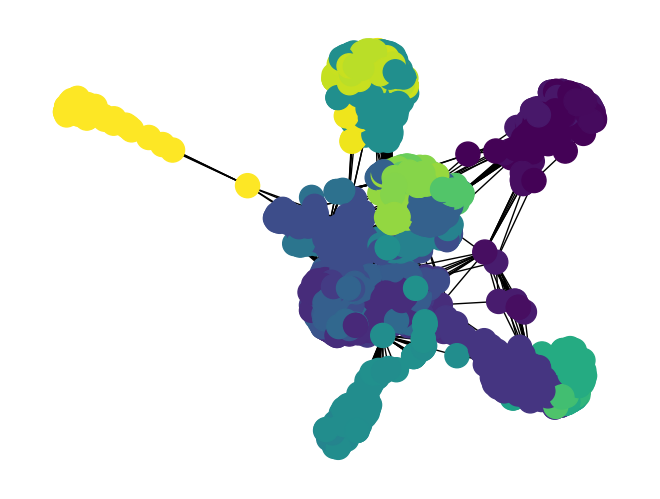

In [22]:
draw_graph(graph_partition_louvain_fb,nodes_connectivity_list_fb)

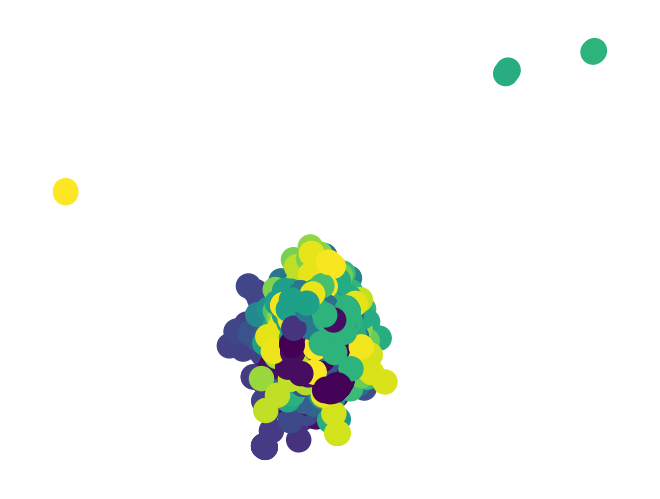

In [24]:
draw_graph(graph_partition_louvain_btc,nodes_connectivity_list_btc)

In [14]:
len(np.unique(graph_partition_louvain_fb[:,1]))

447

In [168]:
L = Louvain(nodes_connectivity_list_fb)
L.phase1()

3808 526 0.6367821450792767
979 142 0.7940242539428678
186 109 0.8072953616427275
69 95 0.8107637722909163
45 93 0.8125999141162368
52 92 0.8171228188213575
13 89 0.8180341511802441
1 89 0.8180352488986659
0 89 0.8180352488986659


In [137]:
np.array(L.G.nodes) == np.arange(4039)

array([ True,  True,  True, ...,  True,  True,  True])

In [166]:
L = Louvain(nodes_connectivity_list_btc)
L.phase1()

4643 1472 0.23639838272398148
586 1233 0.2692378552536174
383 1104 0.285773236785218
283 1038 0.29868239508542194
322 982 0.3123022552481584
388 911 0.33012738278318005
465 820 0.35239688799582397
403 719 0.3722990016861953
260 661 0.38508884784850933
133 628 0.3911010226529519
68 607 0.3940735729332184
34 597 0.39550228766860224
55 590 0.3975461047421966
13 587 0.39789785808051165
5 585 0.3980568601065167
0 585 0.3980568601065167


In [160]:
max(list(L.G.nodes))

5880

In [109]:
# Create a NetworkX graph from the list of edges
Graph = nx.Graph()  # Create an undirected graph
Graph.add_edges_from(nodes_connectivity_list_btc)

In [126]:
a = np.array([1,2,3,4,5,6])
mask = np.where(np.isin(a, [1,3]))[0]
mask


array([0, 2], dtype=int64)

In [39]:
np.array(list(Graph.neighbors(0)))


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [93]:
d = {}
d[0] = 1

In [95]:
d.get(0,True)

True